# Homework 4, Bill Wang Hong

## Part 1. Jupyter Notebook

### a. Import data

In [1]:
import sqlite3
import pandas as pd
import os
import numpy as np
import gspread
import scrapbook as sb
from datetime import datetime, timedelta

%load_ext sql

In [2]:
from_date = '2021-11-05'
to_date = '2021-11-12'
token = 'BTC'
connection_string = 'sqlite:///data/data.db'
#events_db = 'crypto_events_database'
#C:/Users/user/Desktop/Google Drive/Intern & Graduate/Graduate Studies/Programs/MFE/Berkeley/Pre Program Courses/Python/UCB-MFE-python-preprogram/Homeworks/HW4/data/data.db

In [3]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)

data_DF = pd.DataFrame(
    prices,
    columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD', 'token', 'chain']
)

#conn.close()

n_row = data_DF.shape[0]


### b. Hourly Return

In [4]:
data_DF.sort_values(by='ts')

data_DF["return"] = np.log(data_DF["close"]/data_DF["close"].shift(1))


### c. Hourly Volatility

In [5]:
def vol_calc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

data_DF["volatility"] = vol_calc(data_DF)


### d. Maximum Drawdown

In [6]:
#calculate the maximum price up to that hour
rolling_max = []
for i in range(n_row):
    max_at_i = max(max(rolling_max, default = 0), data_DF["close"][i])
    rolling_max.append(max_at_i)
    
#calculate the drawdown from the rolling max price to this hour
drawdown = data_DF["close"]/rolling_max - 1

#calculate the maximum drawdown up to that hour
max_draw = []
for i in range(n_row):
    maxdraw_at_i = min(min(max_draw, default = 0), drawdown[i])
    max_draw.append(maxdraw_at_i)
    
data_DF["max_draw"] =  max_draw


### e. 2x2 Plot

In [7]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

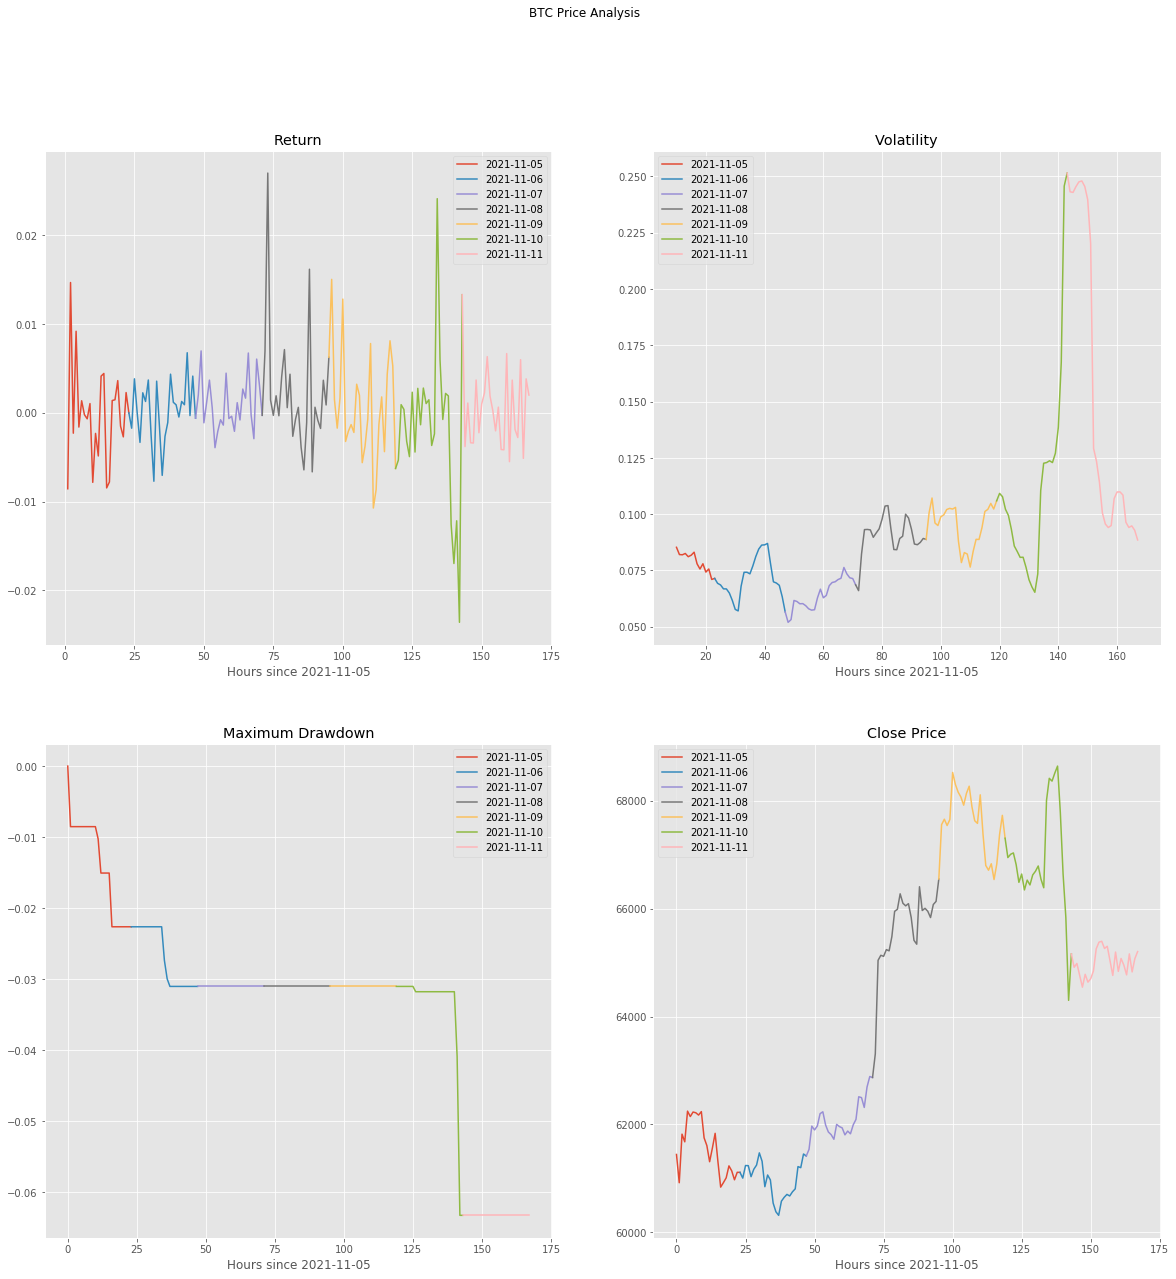

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

# setting up the axis, title and plot orientation
fig.suptitle('BTC Price Analysis')

axes[0,0].set_title("Return")
axes[0,0].set_xlabel('Hours since ' + from_date)

axes[0,1].set_title("Volatility")
axes[0,1].set_xlabel('Hours since ' + from_date)

axes[1,0].set_title("Maximum Drawdown")
axes[1,0].set_xlabel('Hours since ' + from_date)

axes[1,1].set_title("Close Price")
axes[1,1].set_xlabel('Hours since ' + from_date)

# color coding each day

color_list = ['orange', 'yellow', 'green', 'blue', 'purple', 'black', 'red']
for i in range(len(color_list)):
    temp = max(0, i*24-1)
    axes[0,0].plot(data_DF[temp:i*24+24].index, data_DF[temp:i*24+24]["return"])
    axes[0,1].plot(data_DF[temp:i*24+24].index, data_DF[temp:i*24+24]["volatility"])
    axes[1,0].plot(data_DF[temp:i*24+24].index, data_DF[temp:i*24+24]["max_draw"])
    axes[1,1].plot(data_DF[temp:i*24+24].index, data_DF[temp:i*24+24]["close"])

date_list = []
for i in range(7):
    date_list.append(str(pd.to_datetime(from_date)+timedelta(days=i))[:10])

axes[0,0].legend(date_list)
axes[0,1].legend(date_list)
axes[1,0].legend(date_list)
axes[1,1].legend(date_list)


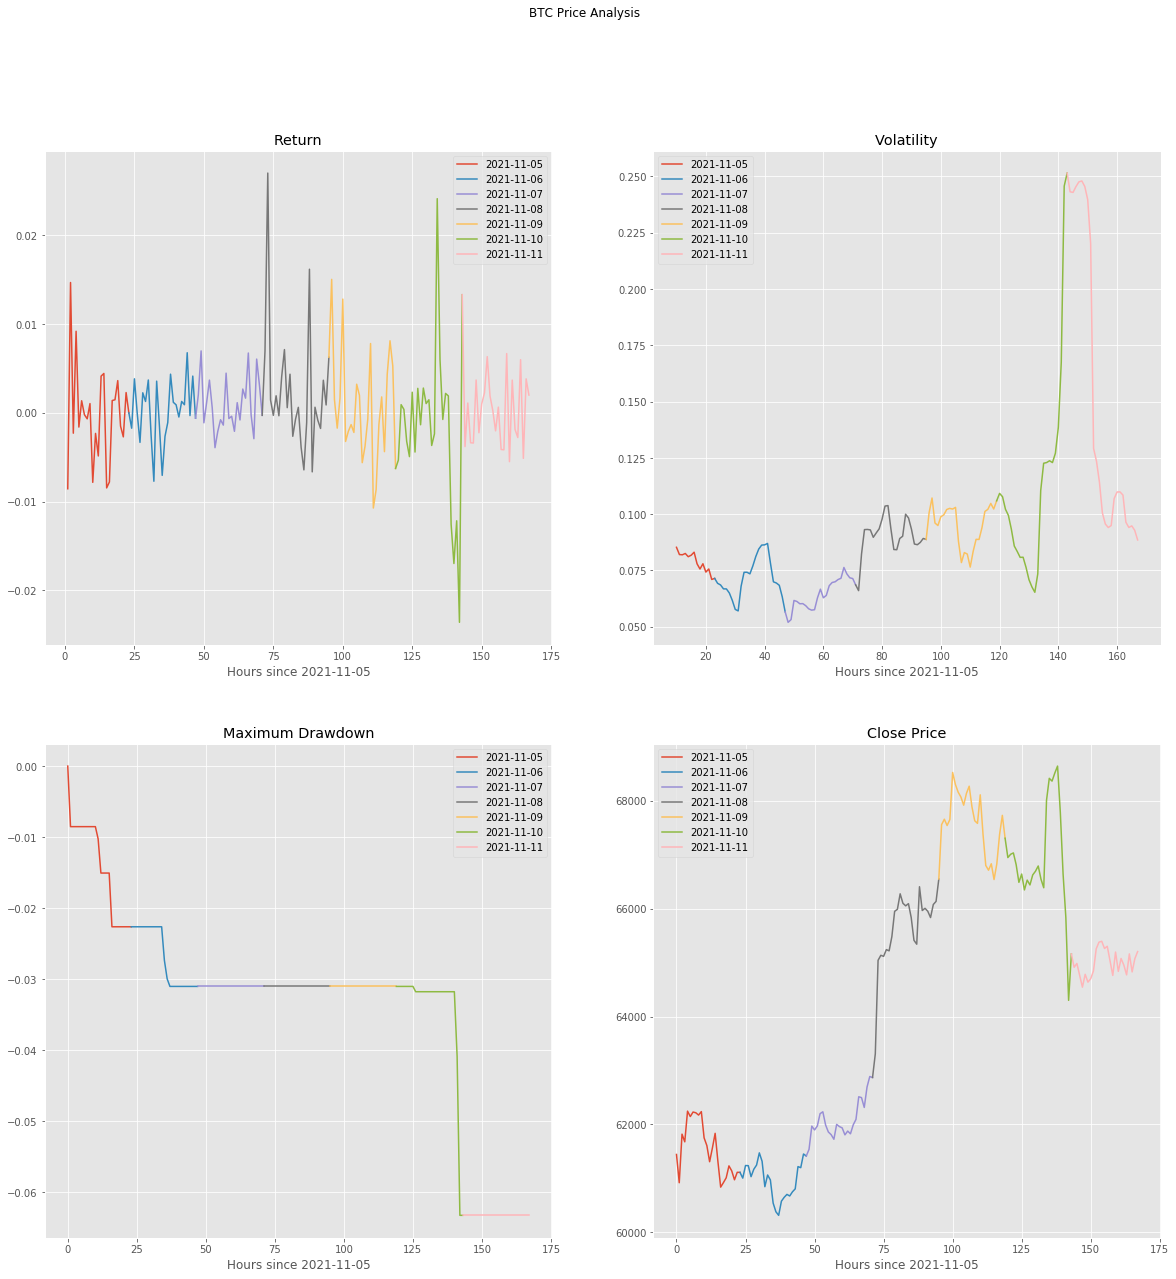

In [10]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('data_DF', data_DF, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)